# Stock Price Prediction Using Recurent Neural Networks (RNN) and Long-Short Memory Model(LSTM)

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense

In [242]:
# Load data
stocks = {
    "AAPL": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\AAPL.csv"),
    "AMZN": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\AMZN.csv"),
    "COKE": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\COKE.csv"),
    "JPM": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\JPM.csv"),
    "MMM": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\MMM.csv"),
    "MSFT": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\MSFT.csv"),
    "PG": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\PG.csv"),
    "WMT": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\WMT.csv")
}

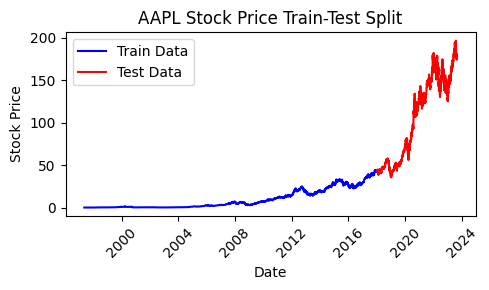

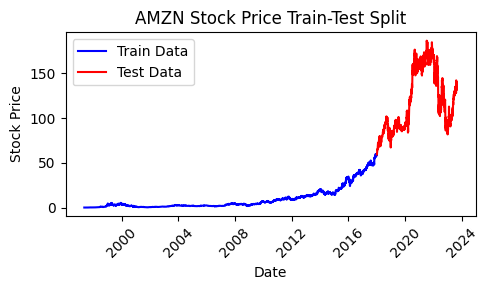

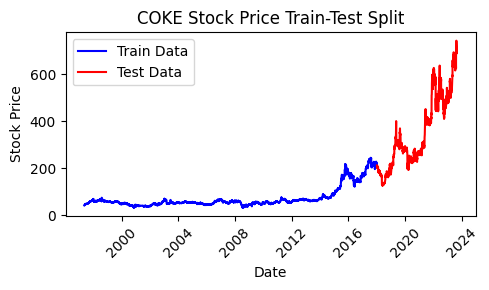

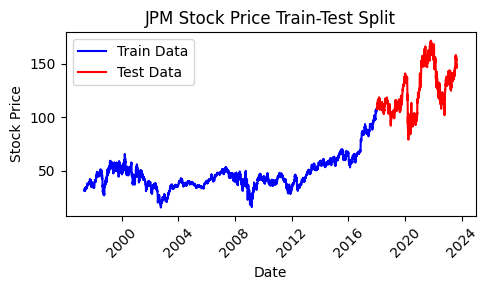

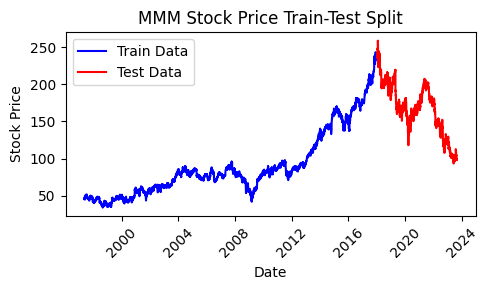

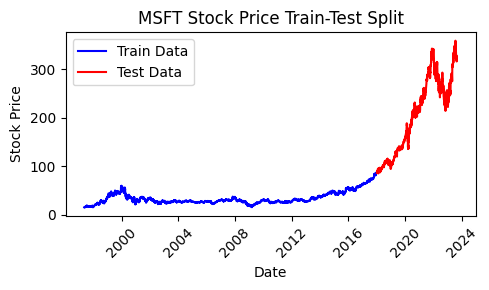

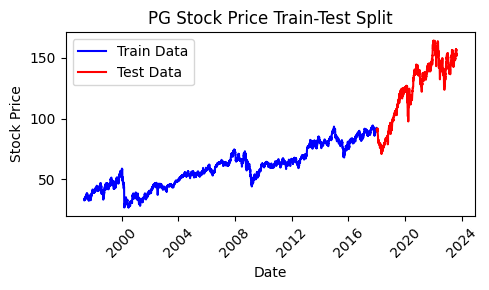

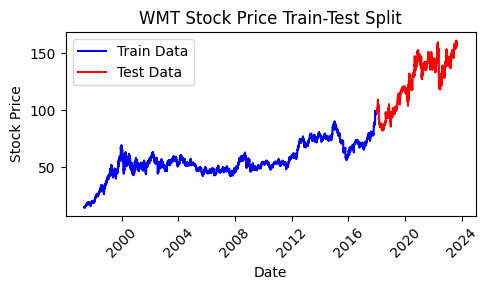

In [243]:
# Plot train and test data splits for each stock
for stock_symbol, stock_data in stocks.items():
    dates = pd.to_datetime(stock_data['Date'])
    prices = stock_data['Close']
    
    # Find the index for the split date
    split_date = pd.to_datetime('2018-01-01')
    split_index = np.where(dates >= split_date)[0][0]

    # Plot train and test data
    plt.figure(figsize=(5, 3))
    plt.plot(dates[:split_index], prices[:split_index], color='blue', label='Train Data')
    plt.plot(dates[split_index:], prices[split_index:], color='red', label='Test Data')
    plt.title(f"{stock_symbol} Stock Price Train-Test Split")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.tight_layout()
    plt.show()

## Getting Data ready for modelling

In [244]:
AAPL = stocks['AAPL']
AMZN = stocks['AMZN']
COKE = stocks['COKE']
JPM = stocks['JPM']
MMM = stocks['MMM']
MSFT = stocks['MSFT']
PG = stocks['PG']
WMT = stocks['WMT']
AAPL.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6608,2023-08-18,172.300003,175.100006,171.960007,174.490005,174.490005,61114200
6609,2023-08-21,175.070007,176.130005,173.740005,175.839996,175.839996,46311900
6610,2023-08-22,177.059998,177.679993,176.250000,177.229996,177.229996,42084200
6611,2023-08-23,178.520004,181.550003,178.330002,181.119995,181.119995,52722800
6612,2023-08-24,180.669998,181.100006,176.009995,176.380005,176.380005,54945800


In [245]:
# Define the prepare_data function
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [246]:
# Define the number of time steps for the LSTM
time_steps = 60

# Define a dictionary to store the prepared data for each stock
prepared_data = {}

# Loop through each stock and prepare data
# Loop through each stock and prepare data
# Loop through each stock and prepare data
for stock_symbol, stock_data in stocks.items():
    split_date = pd.to_datetime('2018-01-01')  # Convert split_date to Timestamp
    
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Convert 'Date' column to DatetimeIndex
    stock_data.set_index('Date', inplace=True)  # Set 'Date' as index
    
    train_data = stock_data[stock_data.index < split_date]
    test_data = stock_data[stock_data.index >= split_date]

    train_prices = train_data['Close'].values.reshape(-1, 1)
    train_scaled = scalers[stock_symbol].transform(train_prices)
    xtrain, ytrain = prepare_data(train_scaled, time_steps)

    test_prices = test_data['Close'].values.reshape(-1, 1)
    test_scaled = scalers[stock_symbol].transform(test_prices)
    xtest, ytest = prepare_data(test_scaled, time_steps)

    prepared_data[stock_symbol] = {
        'xtrain': xtrain,
        'ytrain': ytrain,
        'xtest': xtest,
        'ytest': ytest
    }



## Long Short Term Memory (LSTM) Model for Price Prediction

In [247]:
# Define a dictionary to store the trained models
trained_models = {}

# Loop through each stock and create and train the LSTM model
for stock_symbol in stocks.keys():
    model = Sequential([
        LSTM(50, input_shape=(time_steps, 1), return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(stock_symbol)
    model.fit(prepared_data[stock_symbol]['xtrain'], prepared_data[stock_symbol]['ytrain'], epochs=5, batch_size=32, validation_split=0.2)
    trained_models[stock_symbol] = model

AAPL
Epoch 1/5
129/129 [==============================] - 8s 34ms/step - loss: 6.3562e-05 - val_loss: 2.7866e-05
Epoch 2/5
129/129 [==============================] - 4s 29ms/step - loss: 4.4896e-06 - val_loss: 2.7792e-05
Epoch 3/5
129/129 [==============================] - 4s 29ms/step - loss: 4.3980e-06 - val_loss: 2.6637e-05
Epoch 4/5
129/129 [==============================] - 4s 28ms/step - loss: 3.9039e-06 - val_loss: 2.2701e-05
Epoch 5/5
129/129 [==============================] - 4s 29ms/step - loss: 4.0861e-06 - val_loss: 3.2094e-05
AMZN
Epoch 1/5
129/129 [==============================] - 7s 33ms/step - loss: 4.1154e-05 - val_loss: 6.5901e-05
Epoch 2/5
129/129 [==============================] - 4s 30ms/step - loss: 3.8123e-06 - val_loss: 5.4169e-05
Epoch 3/5
129/129 [==============================] - 4s 29ms/step - loss: 3.6526e-06 - val_loss: 7.0693e-05
Epoch 4/5
129/129 [==============================] - 4s 28ms/step - loss: 3.2071e-06 - val_loss: 6.3980e-05
Epoch 5/5
129/129 

43/43 [==============================] - 1s 12ms/step


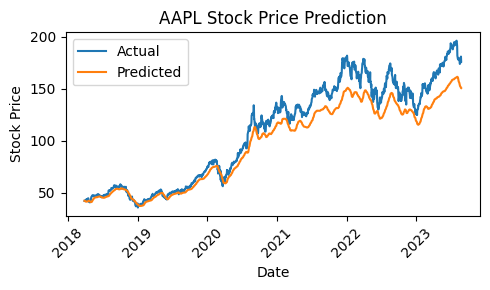

AAPL Stock Price Prediction Evaluation:
MSE: 242.0613
RMSE: 15.5583
MAE: 12.2714
MPAE: 9.55%
Average MSE (Walk Forward): 544.6004
Average MSE (Rolling Origin): 240.0734
43/43 [==============================] - 0s 11ms/step


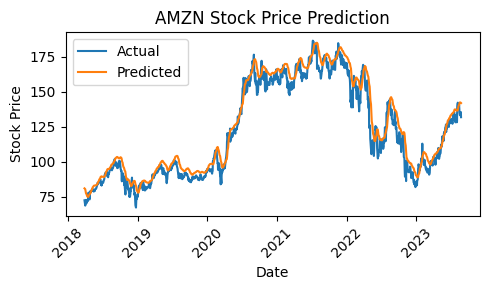

AMZN Stock Price Prediction Evaluation:
MSE: 55.3706
RMSE: 7.4411
MAE: 5.6786
MPAE: 4.92%
Average MSE (Walk Forward): 60.7819
Average MSE (Rolling Origin): 55.7326
43/43 [==============================] - 0s 11ms/step


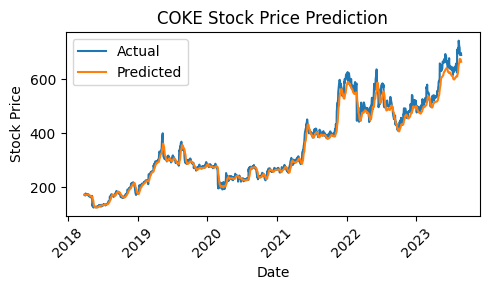

COKE Stock Price Prediction Evaluation:
MSE: 471.6959
RMSE: 21.7186
MAE: 14.4691
MPAE: 3.71%
Average MSE (Walk Forward): 929.0626
Average MSE (Rolling Origin): 453.8337
43/43 [==============================] - 0s 11ms/step


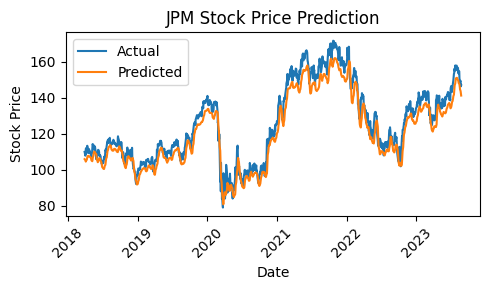

JPM Stock Price Prediction Evaluation:
MSE: 37.1744
RMSE: 6.0971
MAE: 5.2074
MPAE: 4.07%
Average MSE (Walk Forward): 39.3133
Average MSE (Rolling Origin): 37.4293
43/43 [==============================] - 1s 11ms/step


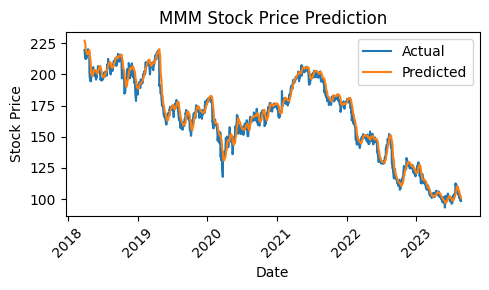

MMM Stock Price Prediction Evaluation:
MSE: 27.4911
RMSE: 5.2432
MAE: 3.8001
MPAE: 2.40%
Average MSE (Walk Forward): 19.3338
Average MSE (Rolling Origin): 27.2053
43/43 [==============================] - 1s 12ms/step


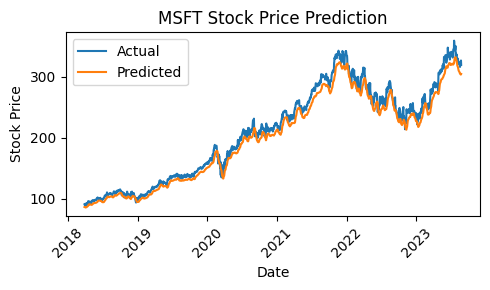

MSFT Stock Price Prediction Evaluation:
MSE: 148.4077
RMSE: 12.1823
MAE: 10.2844
MPAE: 4.85%
Average MSE (Walk Forward): 244.3517
Average MSE (Rolling Origin): 149.2278
43/43 [==============================] - 0s 11ms/step


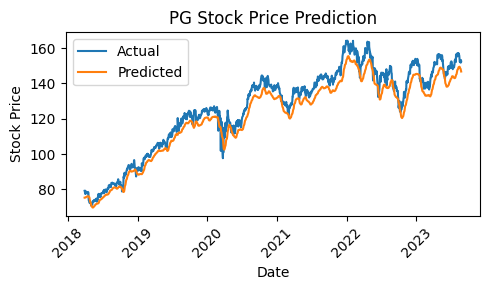

PG Stock Price Prediction Evaluation:
MSE: 36.4594
RMSE: 6.0382
MAE: 5.3741
MPAE: 4.16%
Average MSE (Walk Forward): 51.0775
Average MSE (Rolling Origin): 36.6285
43/43 [==============================] - 0s 11ms/step


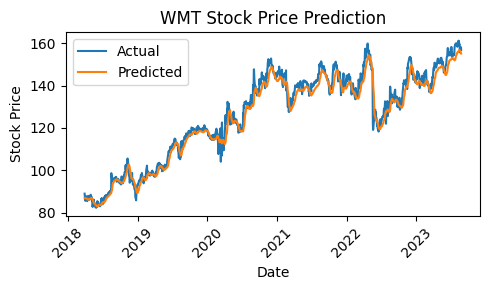

WMT Stock Price Prediction Evaluation:
MSE: 14.1092
RMSE: 3.7562
MAE: 2.7893
MPAE: 2.16%
Average MSE (Walk Forward): 17.2126
Average MSE (Rolling Origin): 14.2552


In [250]:
# Loop through each trained model and make predictions
for stock_symbol, model in trained_models.items():
    predictions = model.predict(prepared_data[stock_symbol]['xtest'])
    predictions_actual = scalers[stock_symbol].inverse_transform(predictions)
    ytest_actual = scalers[stock_symbol].inverse_transform(prepared_data[stock_symbol]['ytest'])

    # Plot the actual test data and predicted results
    plt.figure(figsize=(5, 3))
    plt.plot(AAPL_test.index[time_steps:], ytest_actual, label='Actual')
    plt.plot(AAPL_test.index[time_steps:], predictions_actual, label='Predicted')
    plt.title(f'{stock_symbol} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Model Evaluation
    mse = mean_squared_error(ytest_actual, predictions_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ytest_actual, predictions_actual)
    mpae = np.mean(np.abs((ytest_actual - predictions_actual) / ytest_actual)) * 100

    # Walk Forward Validation
    mse_walk_forward = []
    for i in range(num_walks):
        if i + train_size < len(ytest_actual):
            train_actual = ytest_actual[i : i + train_size]
            train_predicted = predictions_actual[i : i + train_size]
            test_actual = ytest_actual[i + train_size : i + train_size + 1]
            test_predicted = predictions_actual[i + train_size : i + train_size + 1]
            mse_walk_forward.append(mean_squared_error(test_actual, test_predicted))

    average_mse_walk_forward = np.mean(mse_walk_forward)

    # Rolling Origin Evaluation
    mse_rolling = []
    for i in range(num_rolling_windows):
        window_actual = ytest_actual[i : i + window_size]
        window_predicted = predictions_actual[i : i + window_size]
        mse_rolling.append(mean_squared_error(window_actual, window_predicted))

    average_mse_rolling = np.mean(mse_rolling)

    print(f"{stock_symbol} Stock Price Prediction Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MPAE: {mpae:.2f}%")
    print(f"Average MSE (Walk Forward): {average_mse_walk_forward:.4f}")
    print(f"Average MSE (Rolling Origin): {average_mse_rolling:.4f}")


## Recurrent Neural Network For Stock Prediction


In [249]:
def create_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(50, input_shape=input_shape, return_sequences=True),
        SimpleRNN(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model